In [24]:
# Imports and configs
%load_ext autoreload
%autoreload 2
from sklearn.cluster import OPTICS
import src.helpers.model_helpers as mh
import src.helpers.feature_engineering_helper as feh
import src.helpers.logistic_regression_helpers as lrh
import joblib
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

# Finding the root directory
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
# Load modeling dataset and the split indices
X_train, y_train, X_test, y_test = mh.load_model_dataset()

Loading dataset from /Users/c1burns/Documents/UTD/BUAN 6341/project_repo/data/processed/hmda_2024_model.parquet


In [26]:
# Transform and scale data
X_train = feh.log_transform_skewed_features(X_train)
lrh.scale_dataset(X_train)

,loan_amount,income,combined_loan_to_value_ratio,loan_term,intro_rate_period,prepayment_penalty_term,property_value,loan_to_income_ratio,debt_to_income_ratio_60100_x_loan_to_income_ratio,debt_to_income_ratio_5060_x_loan_to_income_ratio,debt_to_income_ratio_4850_x_loan_to_income_ratio,debt_to_income_ratio_4547_x_loan_to_income_ratio
5281787,0.137398,-0.546347,0.812476,0.375900,-0.266993,0.075081,-0.792659,0.776370,-0.272492,-0.31827,-0.283584,-0.301347
8734244,0.682484,-0.635820,-0.527696,0.375900,4.181288,0.075081,0.635437,1.471994,4.103796,-0.31827,-0.283584,-0.301347
7796091,-2.458356,-0.172509,0.868095,-1.039043,-0.266993,0.075081,-0.359942,-2.475793,-0.272492,-0.31827,-0.283584,-0.301347
8511714,5.509745,6.053511,0.301038,-3.268138,-0.266993,0.075081,7.022032,0.003557,-0.272492,-0.31827,-0.283584,-0.301347
1768651,0.531789,-0.057293,-0.210822,0.375900,-0.266993,0.075081,0.338306,0.709876,-0.272492,-0.31827,-0.283584,-0.301347
...,...,...,...,...,...,...,...,...,...,...,...,...
11934,-2.458356,-0.386939,0.301038,0.375900,-0.266993,0.075081,-3.520014,-2.256453,-0.272492,-0.31827,-0.283584,-0.301347
3323522,0.137398,-0.079376,-0.093605,0.375900,-0.266993,0.075081,0.467167,0.296121,-0.272492,-0.31827,-0.283584,-0.301347
5659727,0.992230,0.676182,0.141003,0.375900,-0.266993,0.075081,0.752846,0.469256,-0.272492,-0.31827,-0.283584,-0.301347
81481,0.992230,1.133056,0.185402,0.375900,-0.266993,0.075081,0.732946,0.003557,-0.272492,-0.31827,-0.283584,-0.301347


In [27]:
# Apply PCA
ipca = joblib.load(os.path.join(project_root, "models", "ipca.pkl"))
numeric_cols = ['loan_amount', 'income', 'combined_loan_to_value_ratio', 'loan_term', 'intro_rate_period', 'prepayment_penalty_term',
                'property_value', 'loan_to_income_ratio', 'debt_to_income_ratio_60100_x_loan_to_income_ratio', 'debt_to_income_ratio_5060_x_loan_to_income_ratio', 'debt_to_income_ratio_4850_x_loan_to_income_ratio', 'debt_to_income_ratio_4547_x_loan_to_income_ratio']

X_train_numeric = X_train[numeric_cols]

# Transform numeric cols
X_train_numeric_pca = ipca.transform(X_train_numeric)

In [28]:
# Apply SVD
svd = joblib.load(os.path.join(project_root, "models", "svd.pkl"))
categorical_cols = [col for col in X_train.columns if col not in numeric_cols]

X_train_cat = X_train[categorical_cols]
X_train_cat_svd = svd.transform(X_train_cat)

In [29]:
# Combined transformed with cat again
X_train_pca_svd = np.hstack([X_train_numeric_pca, X_train_cat_svd])

In [30]:
# Train OPTICS model
optics = OPTICS(min_samples=200, xi=0.05, min_cluster_size=0.02)
labels = optics.fit_predict(X_train_pca_svd)


In [31]:
# Identify number of clusters and noise
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)
print(f"Clusters: {n_clusters}, Noise points: {n_noise}")

Clusters: 11, Noise points: 40


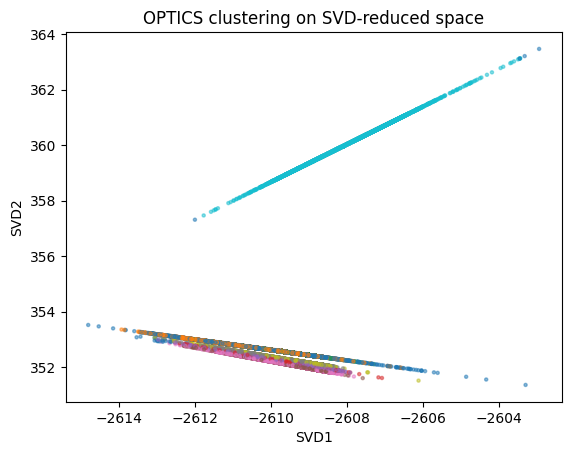

In [32]:
# Visualize
plt.scatter(X_train_pca_svd[:, 0], X_train_pca_svd[:, 1], c=labels, cmap="tab10", s=5, alpha=0.5)
plt.title("OPTICS clustering on SVD-reduced space")
plt.xlabel("SVD1"); plt.ylabel("SVD2")
plt.show()

In [34]:
# We are going to assign labels to the original data and then determine characteristics of those clusters
X_clusters = X_train.copy()
X_clusters["cluster"] = labels
X_clusters = X_clusters[labels != -1]

In [35]:
# Numeric summaries
numeric_summary = X_clusters[numeric_cols + ["cluster"]].groupby("cluster").mean()

# Categorical summaries
categorical_summary = (
    X_clusters[cat_cols + ["cluster"]]
    .groupby("cluster")
    .mean()
    .T
)

In [36]:
# Compute overall averages
global_numeric = X_clusters[numeric_cols].mean()
global_categorical = X_clusters[cat_cols].mean()

# How much each cluster differs from the overall mean
numeric_diff = numeric_summary.subtract(global_numeric)
categorical_diff = categorical_summary.subtract(global_categorical, axis=0)

In [37]:
# Calculate the ten largest differences
def top_differences(df, n=10):
    return (df.abs().rank(ascending=False, axis=0) <= n)

top_numeric = top_differences(numeric_diff)
top_categorical = top_differences(categorical_diff)

In [38]:
# Output details about how cluster means differ from overall means
for cluster_id in numeric_diff.columns:
    print(f"\n=== Cluster {cluster_id} ===")

    # High numeric deviations
    top_num = numeric_diff[cluster_id].sort_values(ascending=False).head(5)
    low_num = numeric_diff[cluster_id].sort_values(ascending=True).head(5)

    print("Higher-than-average numeric features:")
    print(top_num)
    print("\nLower-than-average numeric features:")
    print(low_num)

    # Only select the same cluster column if it exists in categorical_diff
    if cluster_id in categorical_diff.columns:
        top_cat = (
            categorical_diff[cluster_id][categorical_diff[cluster_id] > 0.1]
            .sort_values(ascending=False)
            .head(5)
        )
        if not top_cat.empty:
            print("\nNotably frequent categorical traits:")
            print(top_cat)
        else:
            print("\nNo categorical traits more than +0.1 above global mean.")
    else:
        print("\n(No categorical summary available for this cluster.)")


=== Cluster loan_amount ===
Higher-than-average numeric features:
cluster
8     0.426420
5     0.368208
3     0.326720
1     0.127044
10    0.058612
Name: loan_amount, dtype: float64

Lower-than-average numeric features:
cluster
9   -0.388134
2   -0.274479
0   -0.127431
4   -0.066688
7    0.022205
Name: loan_amount, dtype: float64

(No categorical summary available for this cluster.)

=== Cluster income ===
Higher-than-average numeric features:
cluster
1    0.334071
5    0.173464
8    0.163377
3    0.053004
2    0.015743
Name: income, dtype: float64

Lower-than-average numeric features:
cluster
9    -0.727574
10   -0.318596
4    -0.284550
6    -0.215216
7    -0.203814
Name: income, dtype: float64

(No categorical summary available for this cluster.)

=== Cluster combined_loan_to_value_ratio ===
Higher-than-average numeric features:
cluster
3    0.140811
2    0.140794
5    0.104693
8    0.085370
4    0.078736
Name: combined_loan_to_value_ratio, dtype: float64

Lower-than-average numeri